In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import seaborn as sns
from aesara import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Tue Aug 02 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

scipy     : 1.8.1
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
pymc      : 4.1.3
numpy     : 1.22.4
matplotlib: 3.5.2
arviz     : 0.12.1
seaborn   : 0.11.2
pandas    : 1.4.3

Watermark: 2.3.1



In [3]:
def z(X):
    return ( (X - np.mean(X)) / np.std(X) ) 

def standardize_cols(dframe, colnames):
    for x in colnames:
        dframe[x + "_raw"] = dframe[x]
        dframe[x] = z(dframe[x])

In [4]:
## posterior predictive for 2d regression

def regression_plot(data_frame, trace_obj, model_obj, predict_var, expect_var, out_var):
    posterior_sample = pm.sample_posterior_predictive(trace_obj, model=model_obj)
    ex_post = trace_obj.posterior[expect_var]
    #axis 0 = chain, axis 1 = sample
    ex_mean = ex_post.mean(axis=(0,1))

    _,ax = plt.subplots()
    az.plot_hdi(data_frame[predict_var], ex_post, ax=ax)
    az.plot_hdi(data_frame[predict_var], posterior_sample.posterior_predictive[out_var], ax=ax)
    ax.plot(data_frame[predict_var], data_frame[out_var], "o",alpha=0.5)
    ax.plot(data_frame[predict_var], ex_mean)

5.1 spurious association

In [5]:
data = pd.read_csv("Data/WaffleDivorce.csv", sep=";")

In [6]:
data.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  
0            0.45  
1            0.00  
2            0.00  
3            0.26  
4            0.00

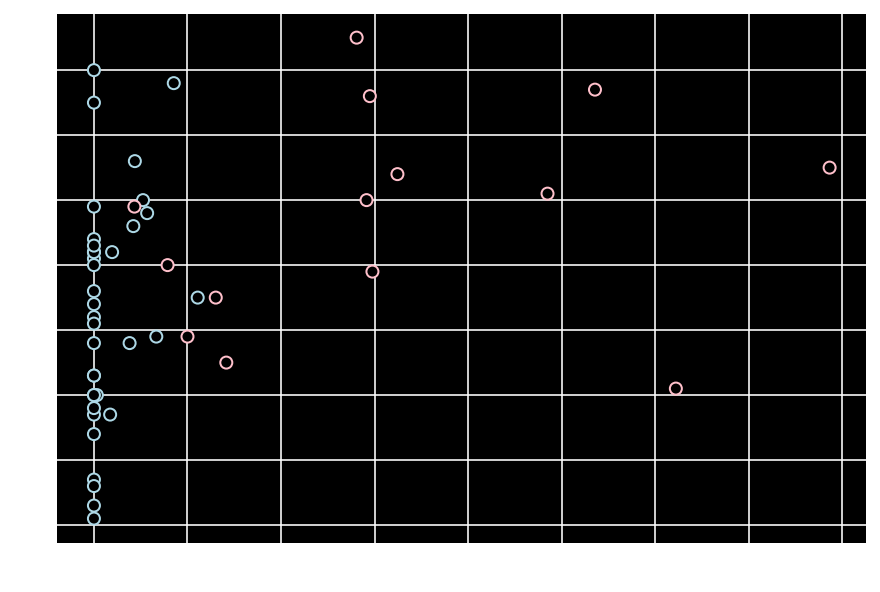

In [7]:
_, ax = plt.subplots()
ax.scatter(data["WaffleHouses"]/data["Population"], data["Divorce"], lw=1, color="black",
edgecolor = data["South"].map({1 : "pink", 0 : "lightblue"}))

In [8]:
## standardize the data
standardize_cols(data, ["Divorce", "Marriage", "MedianAgeMarriage"])
data.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78          -0.612445  0.022874         1.27   
1      Alaska  AK        0.71          -0.693671  1.565536         2.93   
2     Arizona  AZ        6.33          -0.206314  0.049472         0.98   
3    Arkansas  AR        2.92          -1.424706  1.671927         1.70   
4  California  CA       37.25           0.605947 -0.269700         0.39   

    Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0  1.671000        0.79           128      1      435080          964201   
1  1.560044        2.05             0      0           0               0   
2  0.616916        0.74            18      0           0               0   
3  2.114824        1.22            41      1      111115          435450   
4 -0.936470        0.24             0      0           0          379994   

   PropSlaves1860  Divorce_raw  Marriage_raw  MedianAgeMarriage_raw  
0            0.45         12.7          20.2                   25.3  
1            0.00         12.5          26.0                   25.2  
2            0.00         10.8          20.3                   25.8  
3            0.26         13.5          26.4                   24.3  
4            0.00          8.0          19.1                   26.8

In [9]:
predictor_var, ex_var, outcome_var = "MedianAgeMarriage", "mu", "Divorce"
## .values converts to numpy array
outcome_data = data[outcome_var].values

In [10]:
with pm.Model() as m5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bA * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_1 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


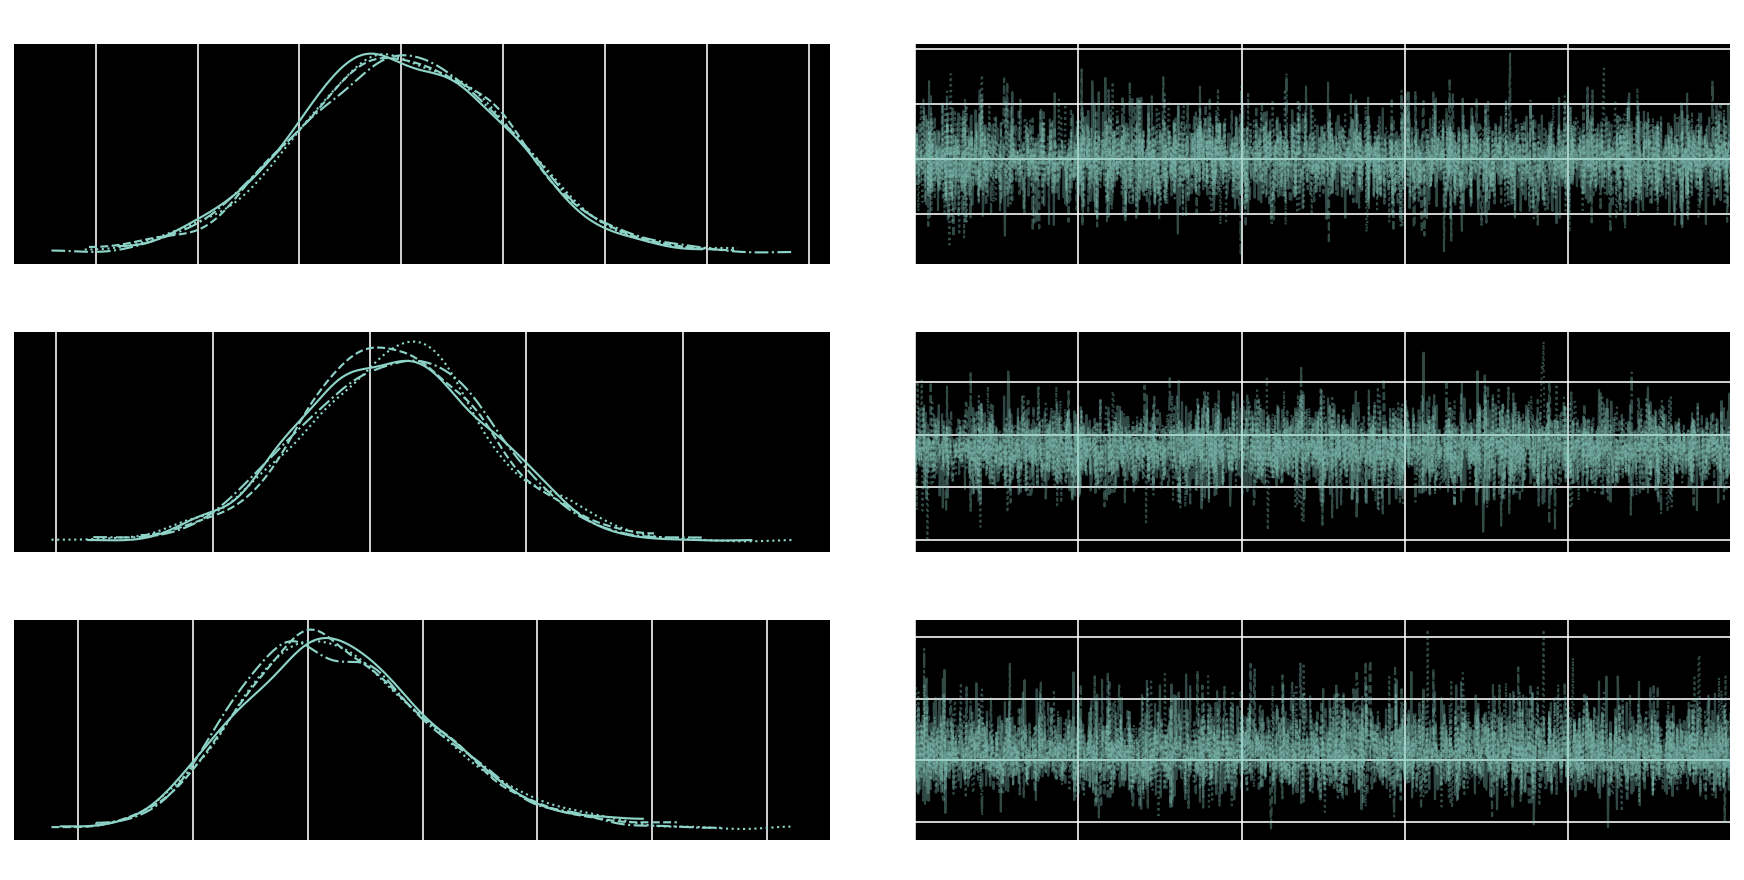

In [11]:
az.plot_trace(trace5_1, ["~mu"]);

prior predictive

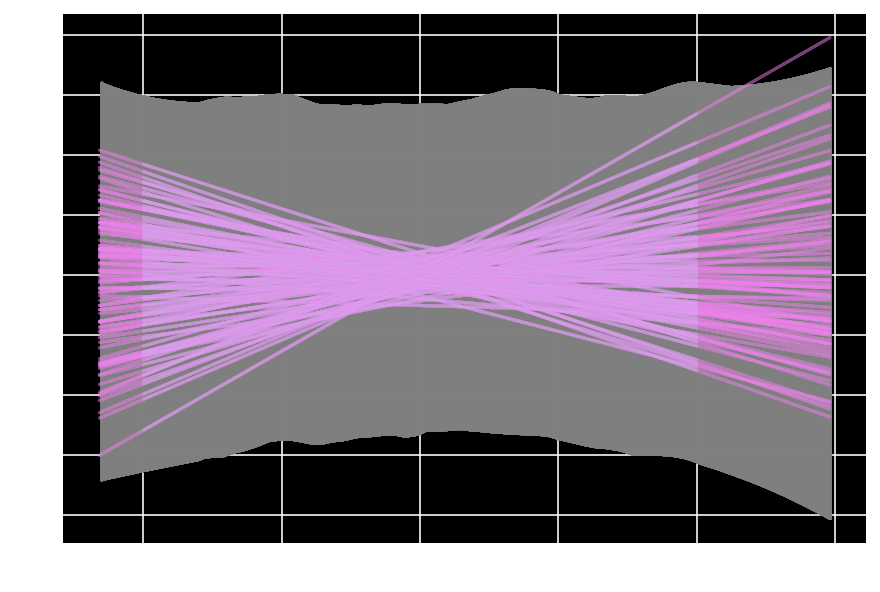

In [12]:
x = np.linspace(2,-2,50)

# chain 0
apriors = np.array(prior_samples.prior["a"][0])
bApriors = np.array(prior_samples.prior["bA"][0])
ex_priors = np.array(prior_samples.prior[ex_var][0])

_,ax = plt.subplots()
for i in range(100):
    #using arbitrary x values
    ax.plot(x, apriors[i] + bApriors[i] * x, alpha=0.5, color="lightblue")
    #using prior samples (identical results)
    ax.plot(data[predictor_var], ex_priors[i], alpha=0.5, color="violet")
    az.plot_hdi(data[predictor_var], prior_samples.prior_predictive[outcome_var], color="gray")


posterior predictive

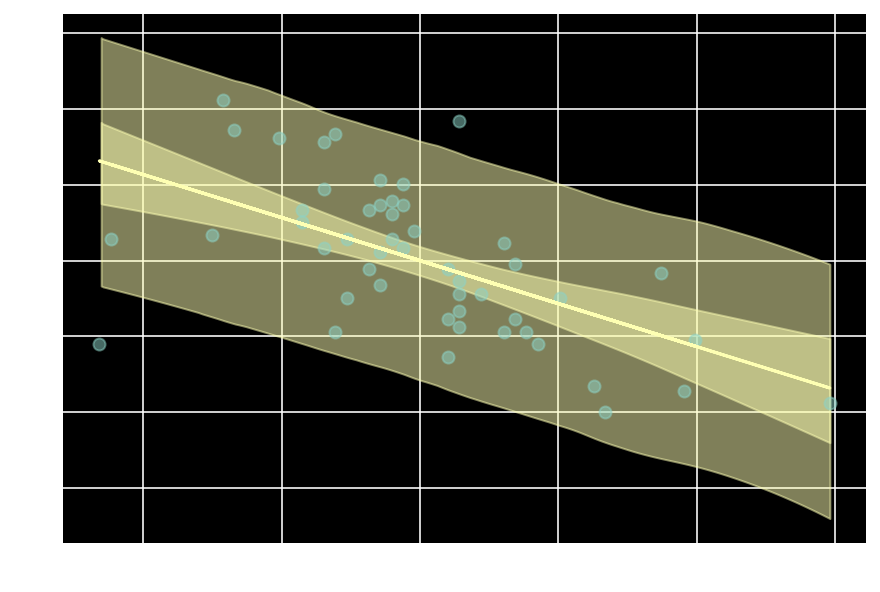

In [13]:
regression_plot(data, trace5_1, m5_1, predictor_var, ex_var, outcome_var)

In [14]:
predictor_var = "Marriage"

with pm.Model() as m5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s",1)
    mu = pm.Deterministic(ex_var, a + bM * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_2 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


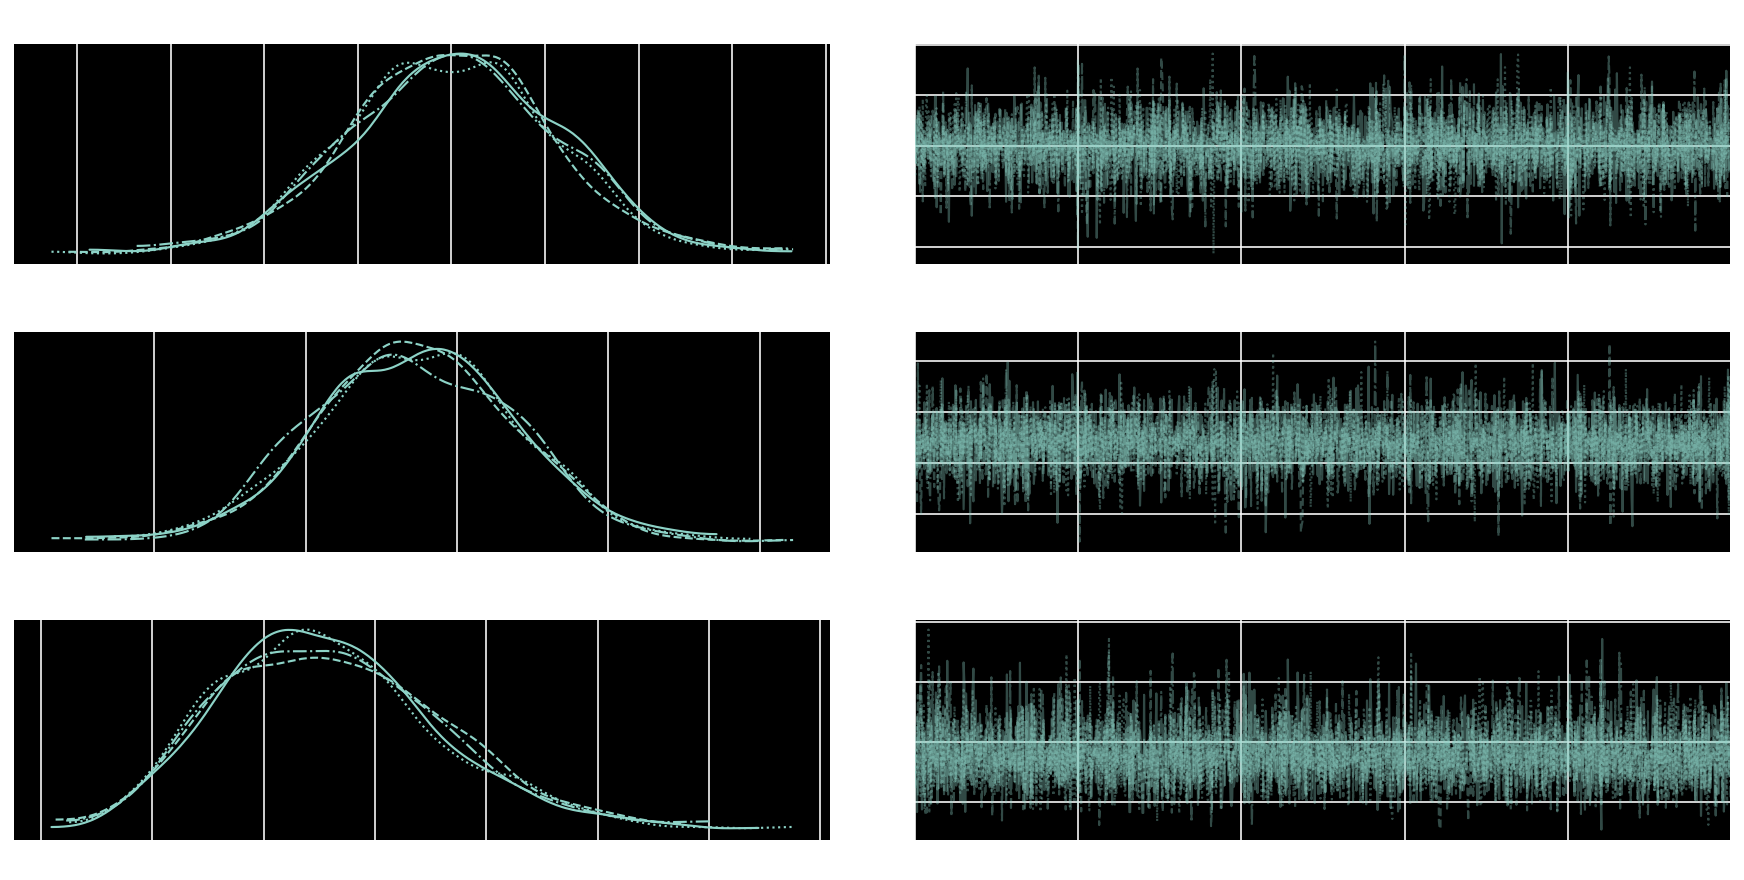

In [40]:
az.plot_trace(trace5_2, ["~mu"]);

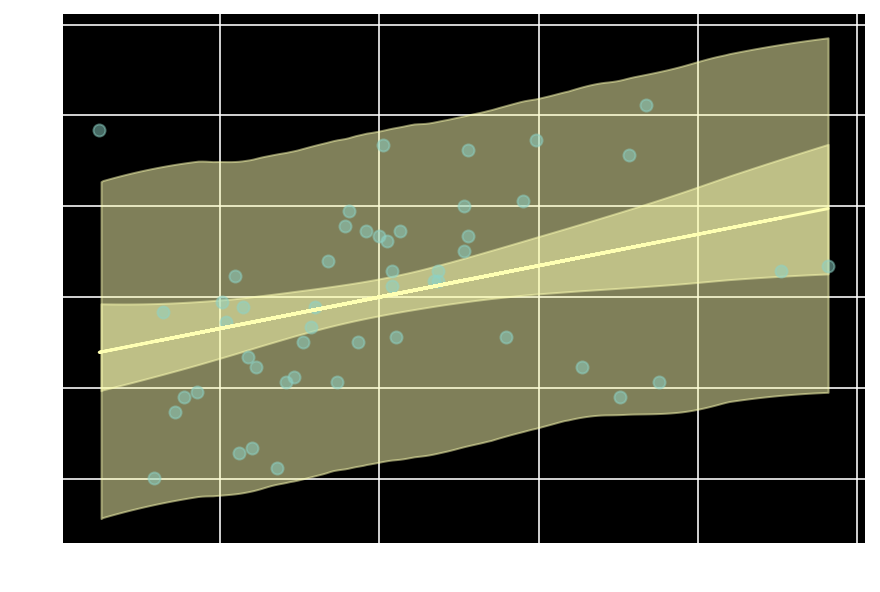

In [16]:
regression_plot(data, trace5_2, m5_2, predictor_var, ex_var, outcome_var)

both predictors

In [17]:
A = data["MedianAgeMarriage"].values
M = data["Marriage"].values

with pm.Model() as m5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bA * A + bM * M)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_3 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [19]:
az.summary(trace5_3, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.002  0.103  -0.191    0.197      0.002    0.002    3523.0    3034.0   
bA -0.609  0.154  -0.888   -0.313      0.003    0.002    2517.0    2792.0   
bM -0.062  0.155  -0.370    0.215      0.003    0.002    2657.0    2946.0   
s   0.835  0.086   0.683    1.000      0.002    0.001    3235.0    2751.0   

    r_hat  
a     1.0  
bA    1.0  
bM    1.0  
s     1.0

marRate only has an effect on divRate in models missing age

marRate and divRate are conditionally independent given age

A -> M, A -> D

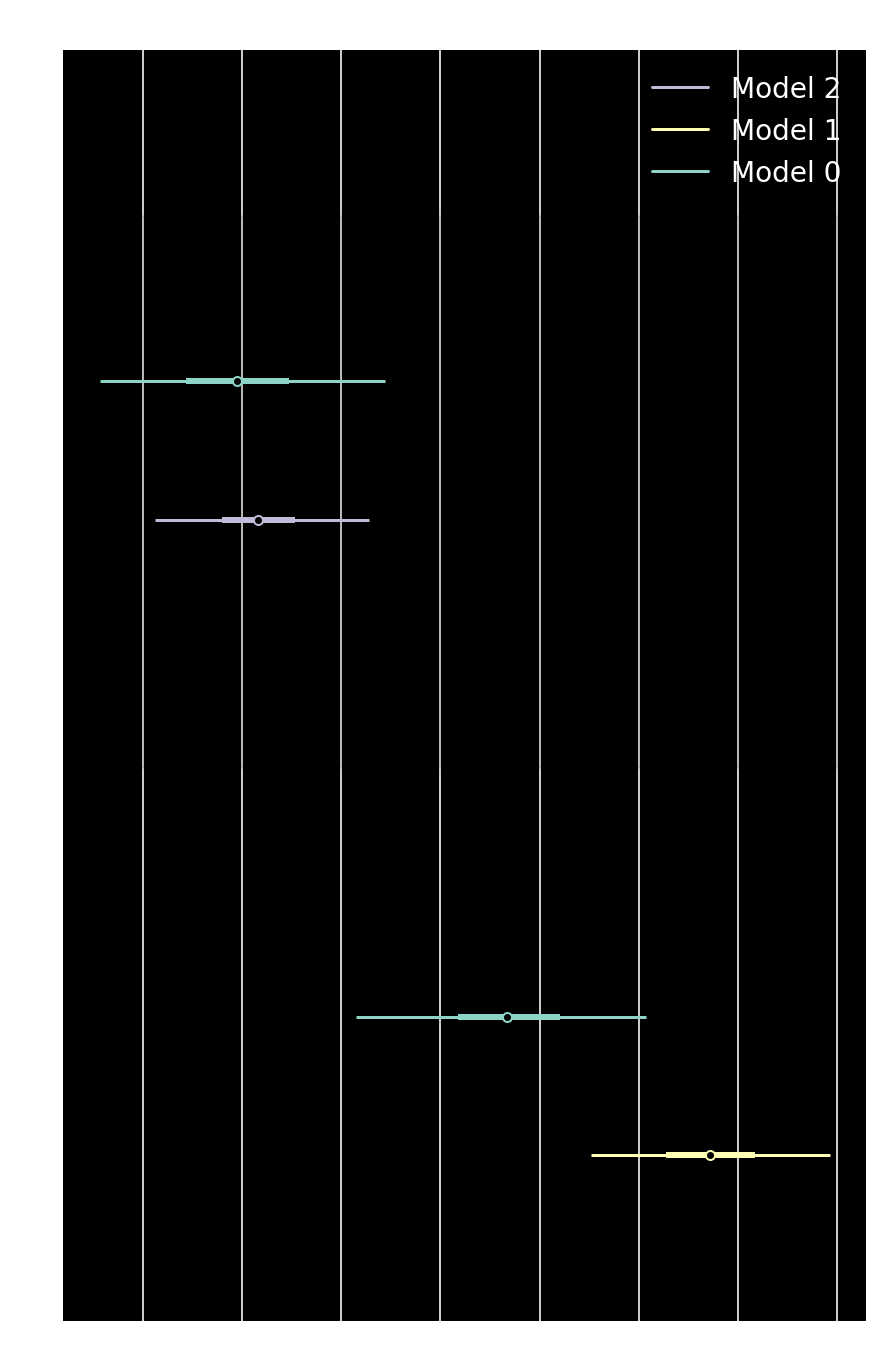

In [42]:
az.plot_forest([trace5_3,trace5_2,trace5_1], var_names=["bA", "bM"], combined=True);

manually removing the effect of Age using Marriage Rate residuals

this happens automatically in the multiple regression above

In [21]:
with pm.Model() as m5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bAM * A)
    marRate = pm.Normal("Marriage", mu, s, observed = data["Marriage"].values)
    trace5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [22]:
mu54mean = trace5_4.posterior[ex_var].mean(axis=(0,1))
data["Mar~Age_resid"] = data["Marriage"] - mu54mean
data.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78          -0.612445  0.022874         1.27   
1      Alaska  AK        0.71          -0.693671  1.565536         2.93   
2     Arizona  AZ        6.33          -0.206314  0.049472         0.98   
3    Arkansas  AR        2.92          -1.424706  1.671927         1.70   
4  California  CA       37.25           0.605947 -0.269700         0.39   

    Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0  1.671000        0.79           128      1      435080          964201   
1  1.560044        2.05             0      0           0               0   
2  0.616916        0.74            18      0           0               0   
3  2.114824        1.22            41      1      111115          435450   
4 -0.936470        0.24             0      0           0          379994   

   PropSlaves1860  Divorce_raw  Marriage_raw  MedianAgeMarriage_raw  \
0            0.45         12.7          20.2                   25.3   
1            0.00         12.5          26.0                   25.2   
2            0.00         10.8          20.3                   25.8   
3            0.26         13.5          26.4                   24.3   
4            0.00          8.0          19.1                   26.8   

   Mar~Age_resid  
0      -0.400953  
1       1.085396  
2      -0.092788  
3       0.684965  
4       0.151175

In [23]:
predictor_var = "Mar~Age_resid"

with pm.Model() as m5_4b:
    a = pm.Normal("a", 0, 0.2)
    bR = pm.Normal("bR", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bR * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    trace5_4b = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Fig 5.4 lower left

additional effect of Marriage Rate after accounting for Age -> Marriage Rate

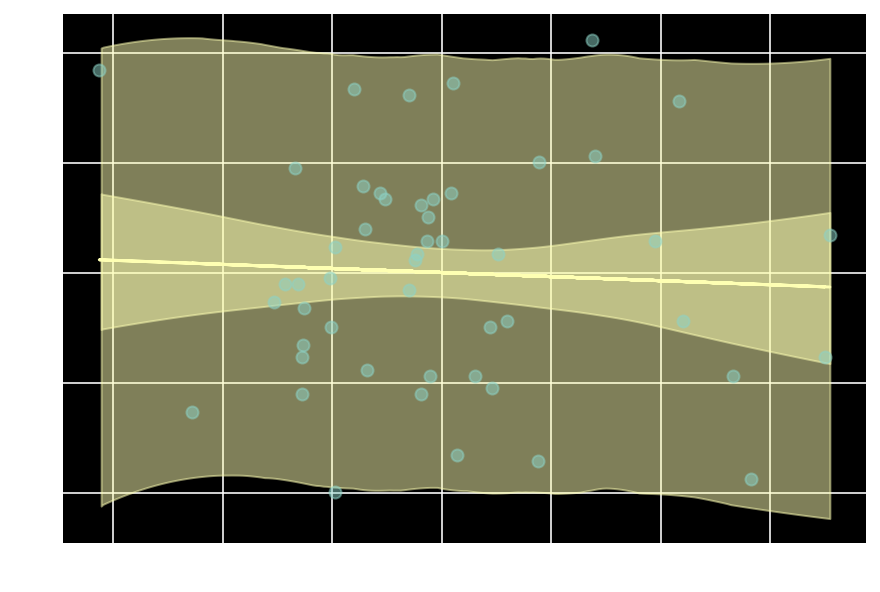

In [24]:
regression_plot(data, trace5_4b, m5_4b, predictor_var, ex_var, outcome_var)

posterior prediction plot

note regression to the mean at extreme values

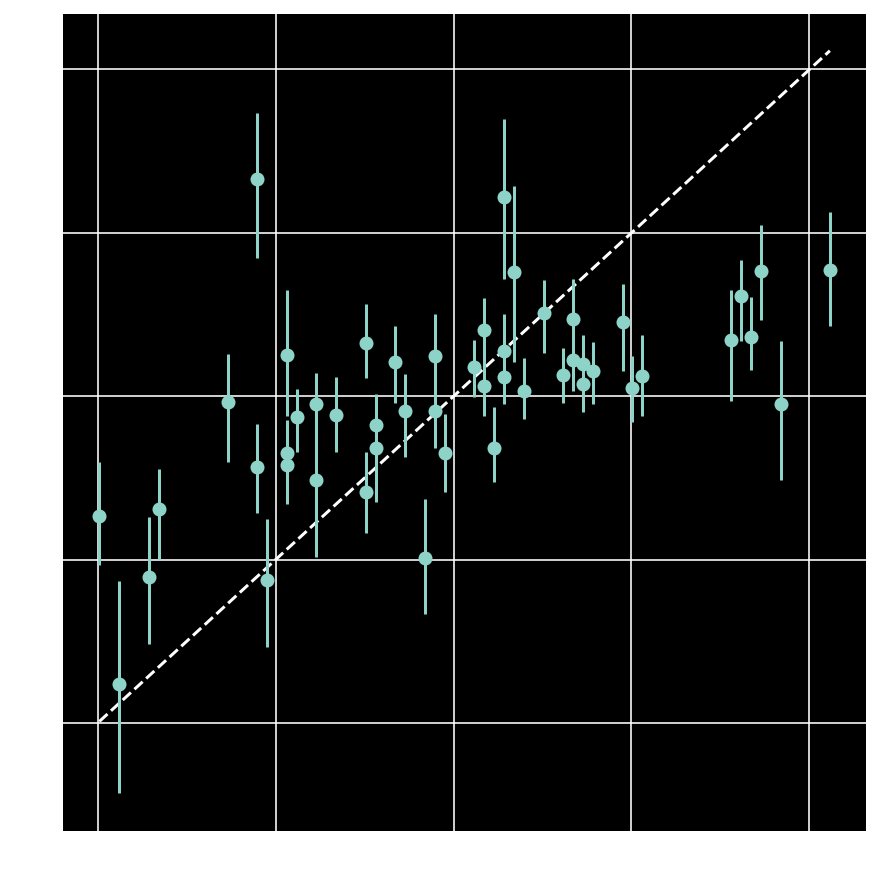

In [43]:
post53 = pm.sample_posterior_predictive(trace5_3, model=m5_3, var_names=[ex_var, outcome_var])

mu_mean = np.array(post53.posterior_predictive["mu"].mean(axis=(0,1)))
mu_PI = az.hdi(post53.posterior_predictive["mu"], 0.89)
D_post_pred = np.array(post53.posterior_predictive["Divorce"].mean(axis=(0,1)))
D_PI = az.hdi(post53.posterior_predictive["Divorce"], 0.89)

_, ax = plt.subplots(figsize=(6,6))
min_x, max_x = outcome_data.min(), outcome_data.max()
ax.plot([min_x, max_x], [min_x, max_x], "w--")
ax.errorbar(outcome_data, D_post_pred, fmt="o", yerr=np.abs(D_post_pred - mu_PI.to_array()[0].T));


"counterfactual" simulations

In [30]:
## use shared variables so we can generate posterior samples with altered values
SH_mar = shared(data["Marriage"].values)
SH_age = shared(data["MedianAgeMarriage"].values)

with pm.Model() as m5_3A:
    ## A -> D <- M
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bA * SH_age + bM * SH_mar)
    o = pm.Normal(outcome_var, mu, s, observed=outcome_data)

    ## A -> M
    aM = pm.Normal("aM", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sM = pm.Exponential("sM", 1)
    muM = pm.Deterministic("muM", aM + bAM * SH_age)
    M = pm.Normal("Marriage", muM, sM, observed=data["Marriage"].values)

    trace5_3A = pm.sample()
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s, aM, bAM, sM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [117]:
az.summary(trace5_3A, var_names=["~mu", "~muM"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a    0.000  0.101  -0.184    0.189      0.001    0.002    5365.0    2833.0   
bA  -0.611  0.162  -0.924   -0.318      0.002    0.002    4377.0    3301.0   
bM  -0.063  0.160  -0.383    0.227      0.002    0.002    4389.0    3063.0   
aM  -0.000  0.090  -0.172    0.163      0.001    0.001    5326.0    2993.0   
bAM -0.691  0.101  -0.876   -0.492      0.001    0.001    4644.0    2918.0   
s    0.834  0.088   0.677    0.999      0.001    0.001    4955.0    3118.0   
sM   0.719  0.074   0.592    0.864      0.001    0.001    4430.0    2615.0   

     r_hat  
a      1.0  
bA     1.0  
bM     1.0  
aM     1.0  
bAM    1.0  
s      1.0  
sM     1.0

In [31]:
## sample_posterior can generate posterior predictive from imaginary data
Aseq = np.linspace(-2, 2, 50)
SH_age.set_value(Aseq)

sim53 = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)

manipulating Age, effect on divRate and marRate

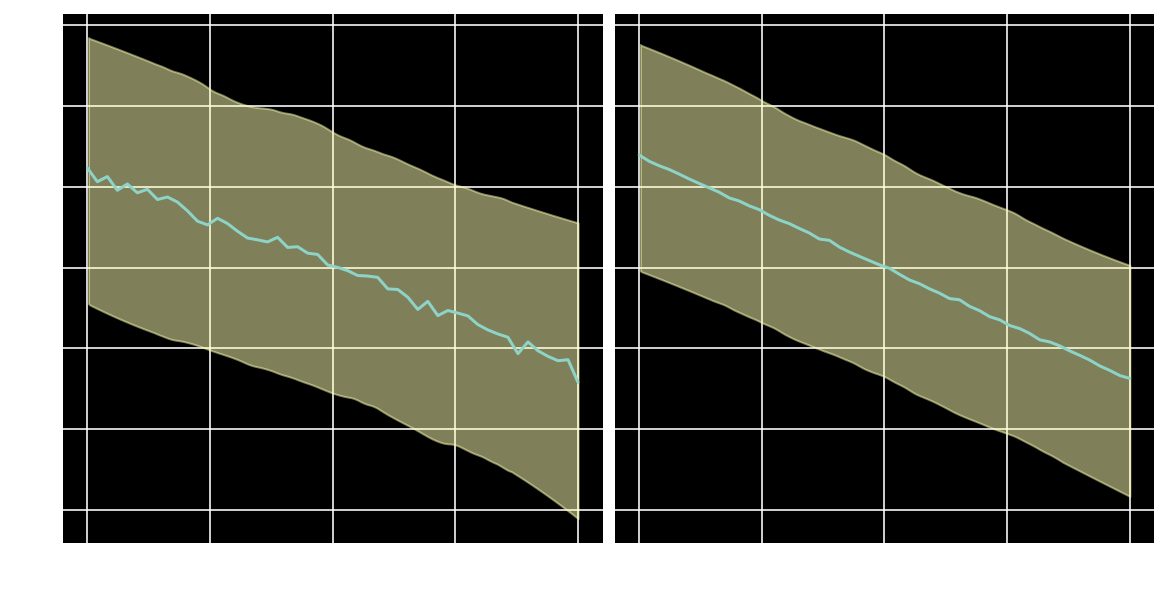

In [38]:
_, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
az.plot_hdi(Aseq, sim53.posterior_predictive[outcome_var], ax=ax[0])
ax[0].plot(Aseq, sim53.posterior_predictive[outcome_var].mean(axis=(0,1)))
az.plot_hdi(Aseq, sim53.posterior_predictive["Marriage"], ax=ax[1])
ax[1].plot(Aseq, sim53.posterior_predictive["Marriage"].mean(axis=(0,1)));

In [119]:
Aseq = (np.linspace(20, 30, 50) - 26.1) / 1.24
SH_age.set_value(Aseq)

sim53b = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)
ex_out = sim53b.posterior_predictive[outcome_var].mean(axis=(0,1))
ex_out[-1] - ex_out[0]

<xarray.DataArray 'Divorce' ()>
array(-5.21555358)

manipulating marRate, holding Age constant at 0 sd

In [75]:
Mseq = np.linspace(-2, 2, 50)
Aseq = np.zeros(50)
SH_mar.set_value(Mseq)
SH_age.set_value(Aseq)

sim53c = pm.sample_posterior_predictive(trace5_3A, model=m5_3A)


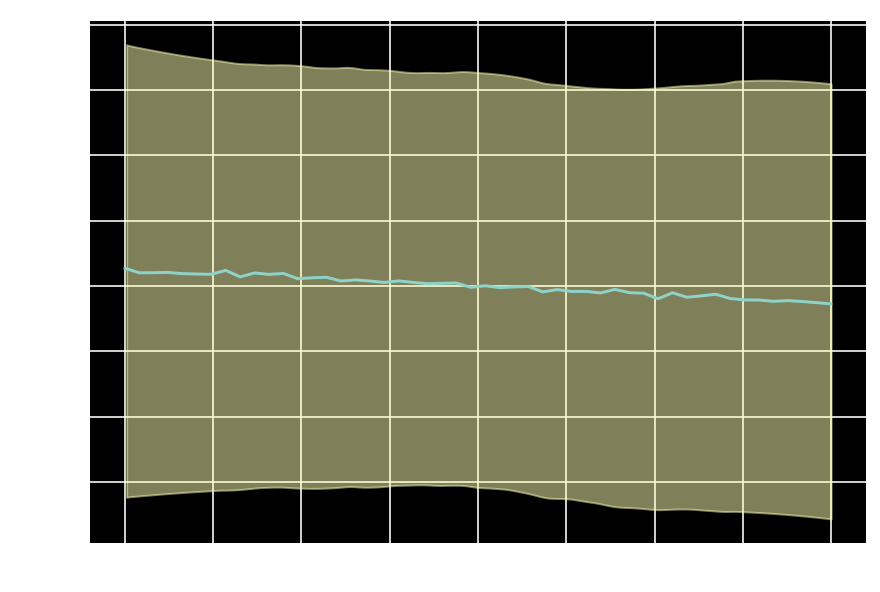

In [76]:
_, ax = plt.subplots()
az.plot_hdi(Mseq, sim53c.posterior_predictive[outcome_var], ax=ax)
ax.plot(Mseq, sim53c.posterior_predictive[outcome_var].mean(axis=(0,1)))

manually generate simulated outcomes

In [109]:
Aseq = np.linspace(-2, 2, 50)

t53Adf = trace5_3A.to_dataframe()
ps = t53Adf.sample(4000, replace=True, ignore_index=True)
a_samp = ps[("posterior", "a")].values
bA_samp = ps[("posterior", "bA")].values
bM_samp = ps[("posterior", "bM")].values
aM_samp = ps[("posterior", "aM")].values
bAM_samp = ps[("posterior", "bAM")].values
s_samp = ps[("posterior", "s")].values
sM_samp = ps[("posterior", "sM")].values

Msim = np.array([np.random.normal(aM_samp + bAM_samp * x, sM_samp) for x in Aseq])
Dsim = np.array([np.random.normal(a_samp + bA_samp * Aseq[i] + bM_samp * Msim[i], s_samp) for i in range(50)])


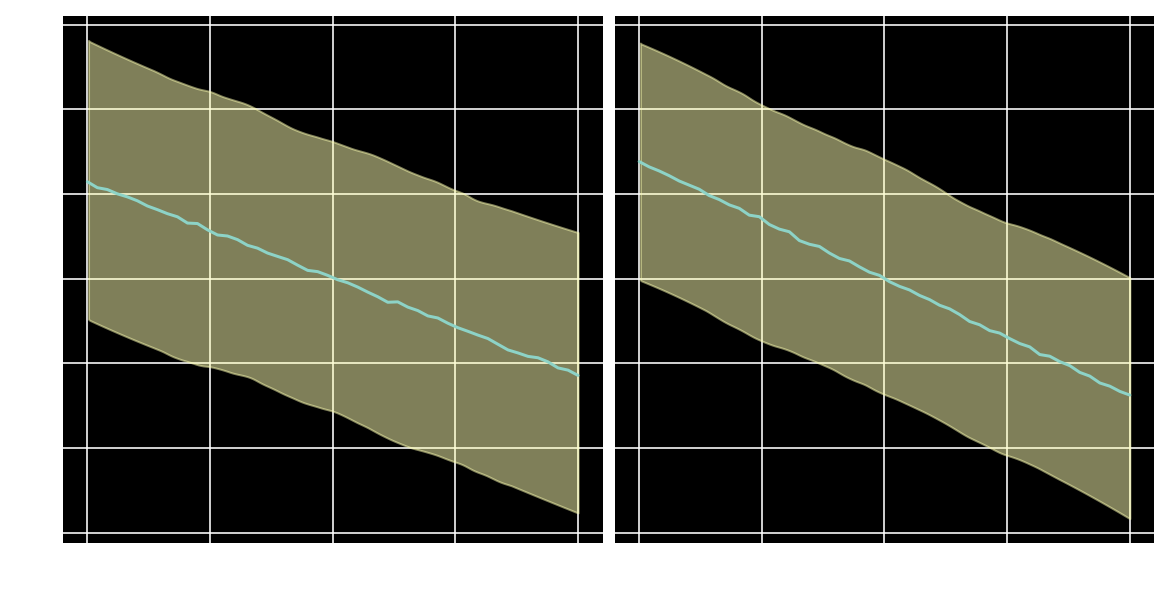

In [112]:
mar_hdi = np.array([az.hdi(row) for row in Msim])
div_hdi = np.array([az.hdi(row) for row in Dsim])

_, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)

az.plot_hdi(Aseq, hdi_data=div_hdi, ax=ax[0])
ax[0].plot(Aseq, np.mean(Dsim,axis=1))
az.plot_hdi(Aseq, hdi_data=mar_hdi, ax=ax[1])
ax[1].plot(Aseq, np.mean(Msim,axis=1))


5.2 masked relationship

In [182]:
data_ = pd.read_csv("Data/milk.csv", sep=";")
data_.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

dropna() returns a slice, not a copy

In [183]:
data_["log_mass"] = np.log(data_["mass"])
standardize_cols(data_, ["kcal.per.g", "neocortex.perc", "log_mass", "mass"])
data = data_.dropna(axis=0)
data.head()


clade             species  kcal.per.g  perc.fat  perc.protein  \
0     Strepsirrhine      Eulemur fulvus   -0.956680     16.60         15.42   
5  New World Monkey  Alouatta seniculus   -1.082788     21.22         23.58   
6  New World Monkey          A palliata   -0.515303     29.66         23.46   
7  New World Monkey        Cebus apella    1.565476     53.41         15.80   
9  New World Monkey          S sciureus    1.754638     50.58         22.33   

   perc.lactose      mass  neocortex.perc  log_mass  kcal.per.g_raw  \
0         67.98 -0.524942       -2.144217 -0.463904            0.49   
5         55.20 -0.389360       -0.524295  0.129697            0.47   
6         46.88 -0.384430       -0.524295  0.143242            0.56   
7         30.79 -0.501934        0.011073 -0.312595            0.89   
9         27.09 -0.577120        0.220040 -1.095320            0.92   

   neocortex.perc_raw  log_mass_raw  mass_raw  
0               55.16      0.667829      1.95  
5               64.54      1.658228      5.25  
6               64.54      1.680828      5.37  
7               67.64      0.920283      2.51  
9               68.85     -0.385662      0.68

In [184]:
SH_neo = shared(data["neocortex.perc"].values)
SH_lm = shared(data["log_mass"].values)
outcome_var = "kcal.per.g"
outcome_data = data[outcome_var].values

In [138]:
with pm.Model() as m5_5a:
    a = pm.Normal("a", 0, 1)
    bN = pm.Normal("bN", 0, 1)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bN * SH_neo)
    kcal = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samp = pm.sample_prior_predictive()

prior predictive indicates priors are too broad

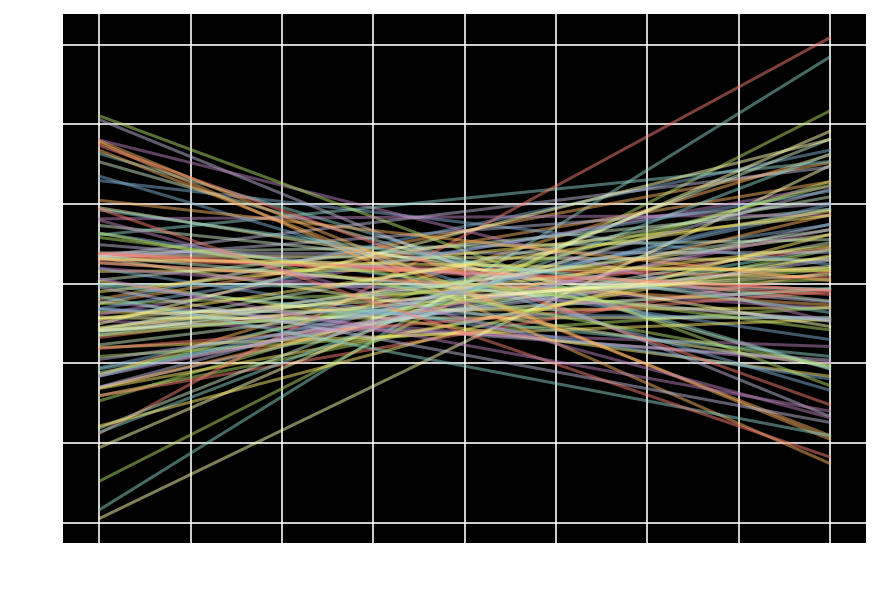

In [169]:
asamp = prior_samp.prior["a"].mean(axis=0).values
bNsamp = prior_samp.prior["bN"].mean(axis=0).values
x = np.linspace(-2, 2, 50)

_, ax = plt.subplots()
for i in range(100):
    ax.plot(x, asamp[i] + bNsamp[i] * x,  alpha=0.5)
    #ax.plot(data["neocortex.perc"].values, prior_samp.prior["mu"].mean(axis=0)[i], alpha=0.5)



In [175]:
with pm.Model() as m5_5:
    a = pm.Normal("a", 0, 0.2)
    bN = pm.Normal("bN", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bN * SH_neo)
    kcal = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samp = pm.sample_prior_predictive()

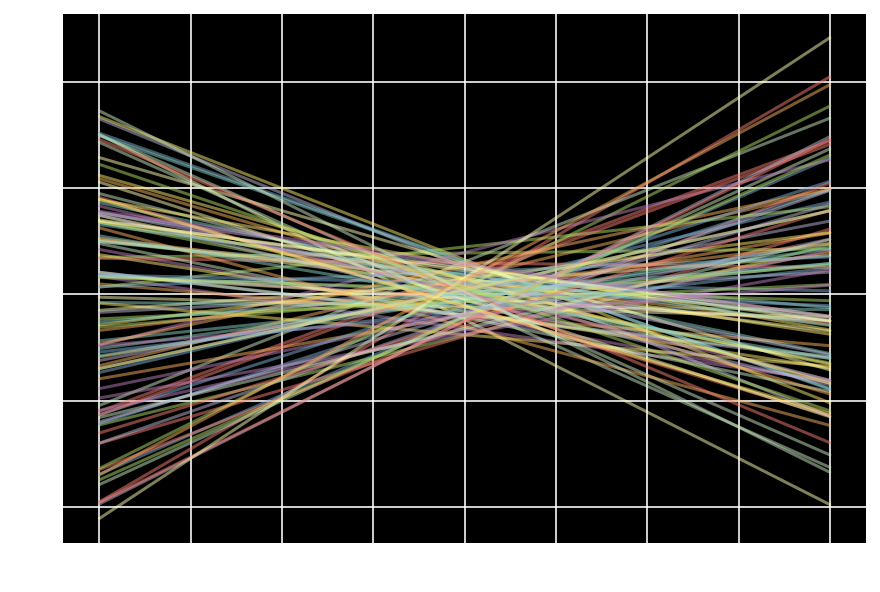

In [176]:
asamp = prior_samp.prior["a"].mean(axis=0).values
bNsamp = prior_samp.prior["bN"].mean(axis=0).values
x = np.linspace(-2, 2, 50)

_, ax = plt.subplots()
for i in range(100):
    ax.plot(x, asamp[i] + bNsamp[i] * x,  alpha=0.5)
    #ax.plot(data["neocortex.perc"].values, prior_samp.prior["mu"].mean(axis=0)[i], alpha=0.5)

In [178]:
trace5_5 = pm.sample(model=m5_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [180]:
az.summary(trace5_5, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.036  0.159  -0.272    0.325      0.002    0.002    4478.0    3112.0   
bN  0.128  0.241  -0.344    0.565      0.003    0.003    4791.0    3049.0   
s   1.128  0.209   0.788    1.516      0.003    0.002    4887.0    2967.0   

    r_hat  
a     1.0  
bN    1.0  
s     1.0

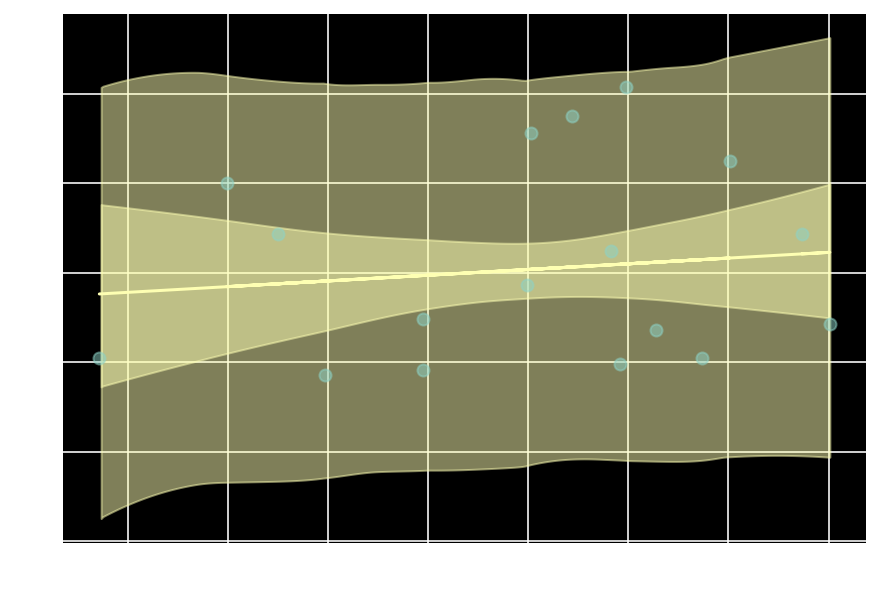

In [181]:
regression_plot(data, trace5_5, m5_5, "neocortex.perc", "mu", outcome_var)

In [190]:
with pm.Model() as m5_6:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bM * SH_lm)
    kcal = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    trace5_6 = pm.sample()

az.summary(trace5_6, var_names=["~mu"])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.043  0.158  -0.270    0.320      0.003    0.002    3848.0    2702.0   
bM -0.274  0.214  -0.674    0.140      0.003    0.002    4917.0    3170.0   
s   1.074  0.194   0.753    1.442      0.003    0.002    4504.0    3035.0   

    r_hat  
a     1.0  
bM    1.0  
s     1.0

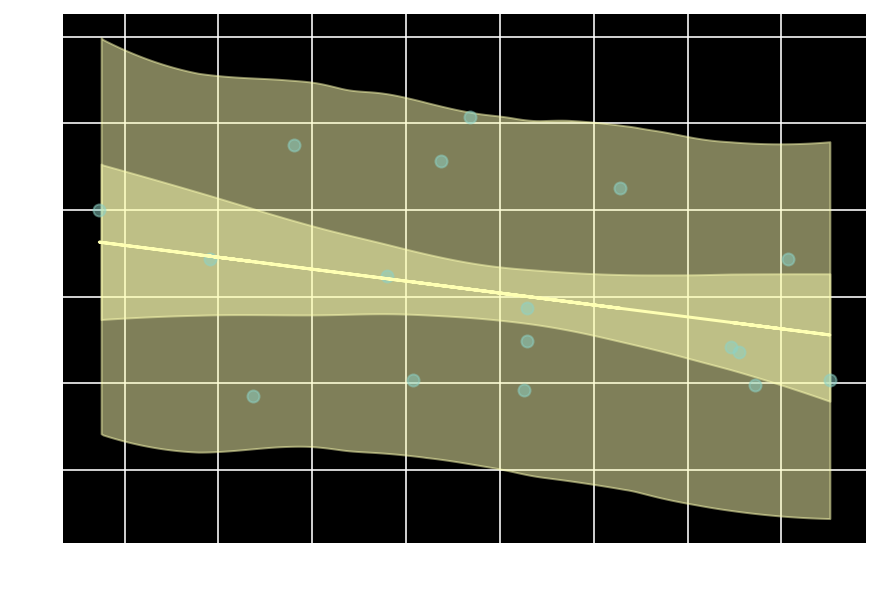

In [186]:
regression_plot(data, trace5_6, m5_6, "log_mass", "mu", outcome_var)

In [188]:
with pm.Model() as m5_7:
    a = pm.Normal("a", 0, 0.2)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bM*SH_lm + bN*SH_neo)
    kcal = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    trace5_7 = pm.sample()

az.summary(trace5_7, var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.063  0.147  -0.208    0.337      0.003    0.002    3147.0    2648.0   
bN  0.603  0.273   0.086    1.121      0.005    0.004    2588.0    2561.0   
bM -0.645  0.244  -1.097   -0.178      0.005    0.003    2496.0    2654.0   
s   0.882  0.182   0.586    1.236      0.003    0.003    2842.0    2363.0   

    r_hat  
a     1.0  
bN    1.0  
bM    1.0  
s     1.0

mass and neocortex effects more visible in combined model

in single var models, total effect is masked because the predictors have opposite effects and are correlated

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

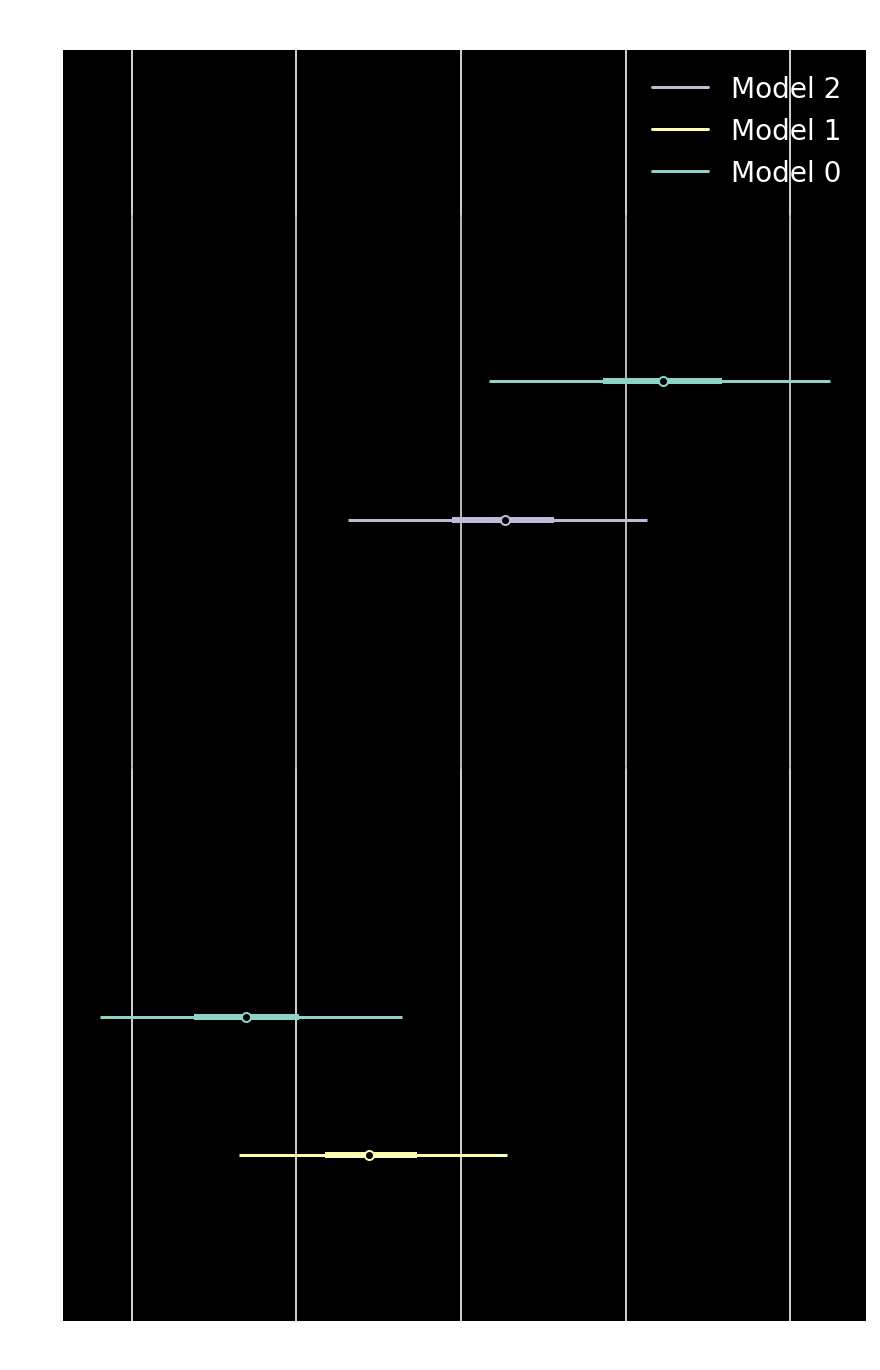

In [205]:
az.plot_forest([trace5_7, trace5_6, trace5_5], var_names=["bN", "bM"], combined=True)

"counterfactual" effect of each predictor, holding the other constant

In [199]:
Nseq = np.linspace(data["neocortex.perc"].min() - 0.15, data["neocortex.perc"].max() + 0.15, 30)
SH_neo.set_value(Nseq)
SH_lm.set_value(np.zeros(30))
post_samp_neo = pm.sample_posterior_predictive(trace5_7, model=m5_7, var_names=["mu", outcome_var])

Mseq = np.linspace(data["log_mass"].min() - 0.15, data["log_mass"].max() + 0.15, 30)
SH_lm.set_value(Mseq)
SH_neo.set_value(np.zeros(30))
post_samp_mass = pm.sample_posterior_predictive(trace5_7, model=m5_7, var_names=["mu", outcome_var])


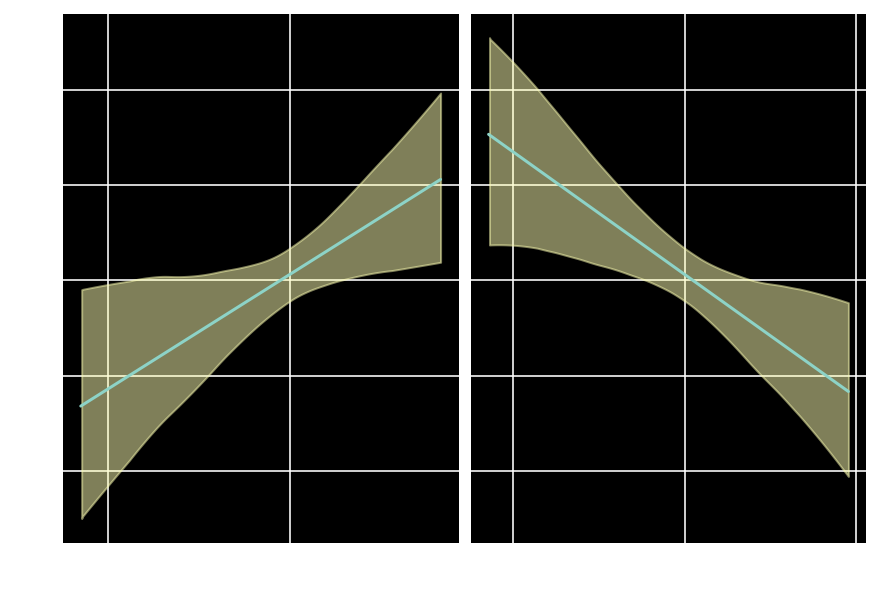

In [204]:
mu_post_neo = post_samp_neo.posterior_predictive["mu"]
mu_mean_neo = mu_post_neo.mean(axis=(0,1))
mu_post_mass = post_samp_mass.posterior_predictive["mu"]
mu_mean_mass = mu_post_mass.mean(axis=(0,1))

_,ax = plt.subplots(1,2,sharey=True)
az.plot_hdi(Nseq, mu_post_neo, ax=ax[0])
ax[0].plot(Nseq, mu_mean_neo)
az.plot_hdi(Mseq, mu_post_mass, ax=ax[1])
ax[1].plot(Mseq, mu_mean_mass)


categorical predictors

In [206]:
d = pd.read_csv("Data/Howell1.csv", sep=";")
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [226]:
with pm.Model() as m5_8:
    s = pm.Exponential("s",1)
    ## array of len 2
    mu = pm.Normal("mu", 178, 20, shape=2)
    ## values in "male" work as index variables
    height = pm.Normal("height", mu[d["male"]], s, observed=d["height"].values)
    ## two-group difference
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])
    trace5_8 = pm.sample()

az.summary(trace5_8)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]  134.933  1.550  132.027  137.838      0.020    0.014    6087.0   
mu[1]  142.567  1.651  139.445  145.604      0.020    0.014    6562.0   
s       26.765  0.787   25.336   28.250      0.010    0.007    5823.0   
diff    -7.634  2.238  -11.872   -3.519      0.027    0.020    6741.0   

       ess_tail  r_hat  
mu[0]    3344.0    1.0  
mu[1]    3293.0    1.0  
s        2905.0    1.0  
diff     3304.0    1.0

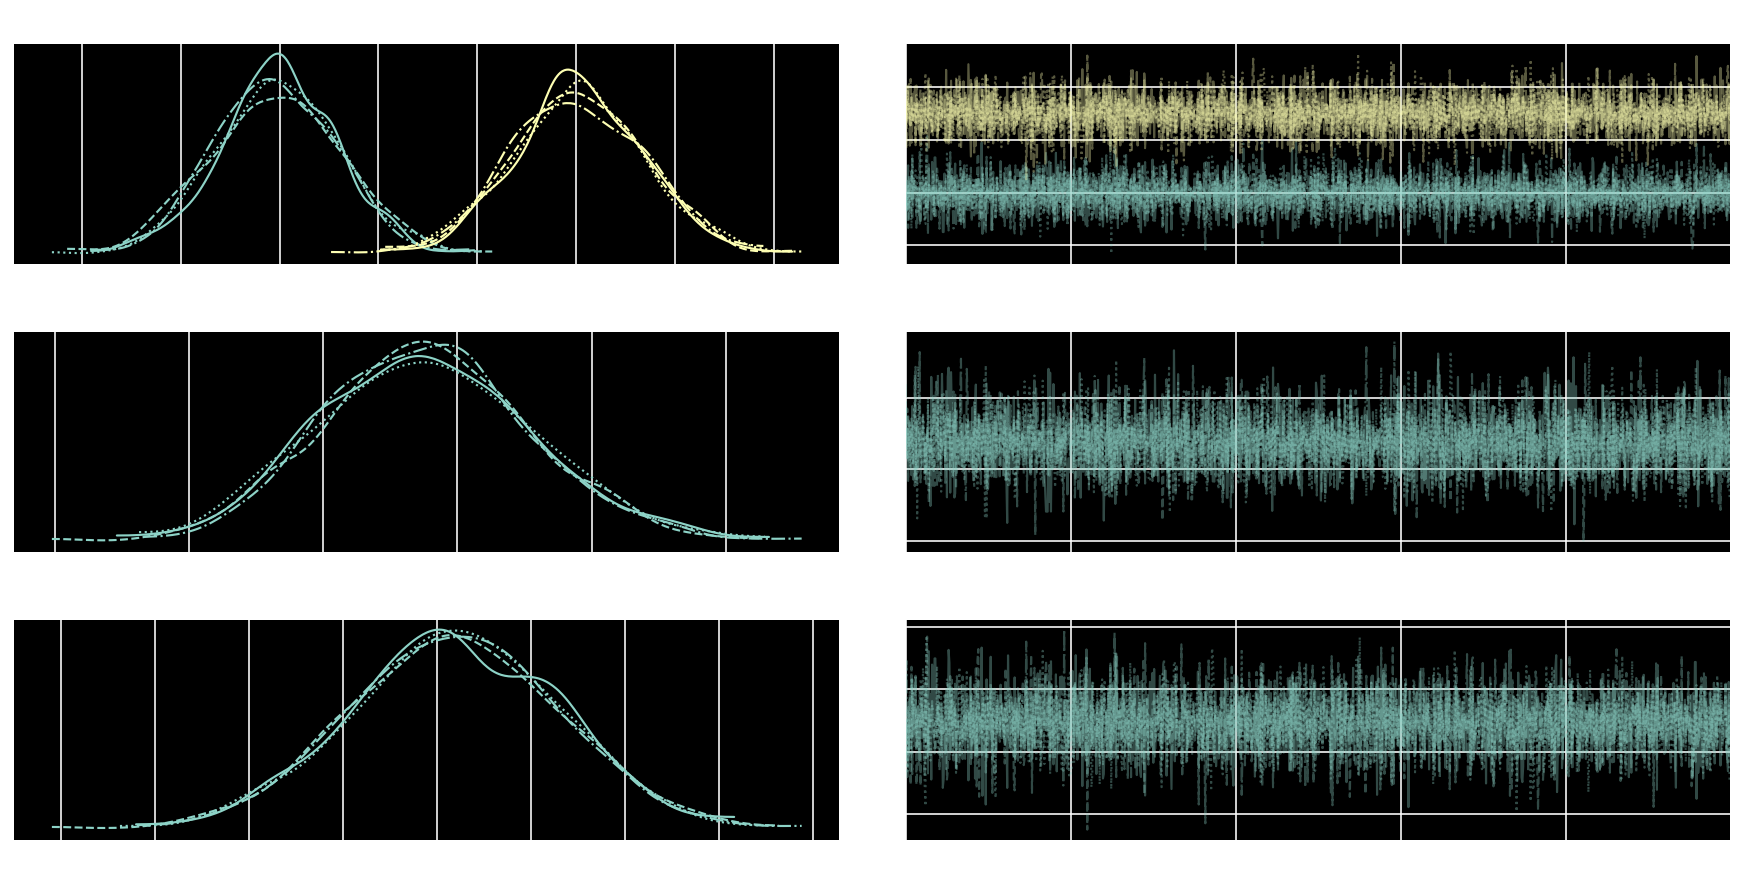

In [269]:
az.plot_trace(trace5_8);

more than 2 categories

In [275]:
d = pd.read_csv("Data/milk.csv", sep=";")
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

In [276]:
cladeF = pd.Categorical(d["clade"])
Nclades = len(cladeF.categories)
d["clade_id"] = cladeF.codes
standardize_cols(d, ["kcal.per.g","perc.fat","perc.lactose"])
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus   -0.956680 -1.238788         15.42   
1  Strepsirrhine        E macaco   -0.830572 -1.048593         16.91   
2  Strepsirrhine        E mongoz   -1.145842 -1.416162         16.85   
3  Strepsirrhine   E rubriventer   -1.019734 -1.359174         13.18   
4  Strepsirrhine     Lemur catta   -0.263087 -0.478006         19.50   

   perc.lactose  mass  neocortex.perc  clade_id  kcal.per.g_raw  perc.fat_raw  \
0      1.330401  1.95           55.16         3            0.49         16.60   
1      1.029186  2.09             NaN         3            0.51         19.27   
2      1.407153  2.51             NaN         3            0.46         14.11   
3      1.614963  1.62             NaN         3            0.48         14.91   
4      0.261666  2.19             NaN         3            0.60         27.28   

   perc.lactose_raw  
0             67.98  
1             63.82  
2             69.04  
3             71.91  
4             53.22

In [270]:
with pm.Model() as m5_9:
    s = pm.Exponential("s", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=Nclades)
    #likelihood (of each data point)
    kcal = pm.Normal("kcal", mu[d["clade_id"]], s, observed=d["kcal.per.g"])
    trace5_9 = pm.sample()

az.summary(trace5_9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu[0] -0.464  0.238  -0.923   -0.028      0.003    0.002    5241.0    3356.0   
mu[1]  0.358  0.230  -0.084    0.776      0.004    0.003    4225.0    3112.0   
mu[2]  0.640  0.286   0.122    1.197      0.004    0.003    4801.0    3008.0   
mu[3] -0.547  0.304  -1.126    0.010      0.004    0.003    5224.0    3169.0   
s      0.813  0.119   0.610    1.043      0.002    0.001    3341.0    2843.0   

       r_hat  
mu[0]    1.0  
mu[1]    1.0  
mu[2]    1.0  
mu[3]    1.0  
s        1.0

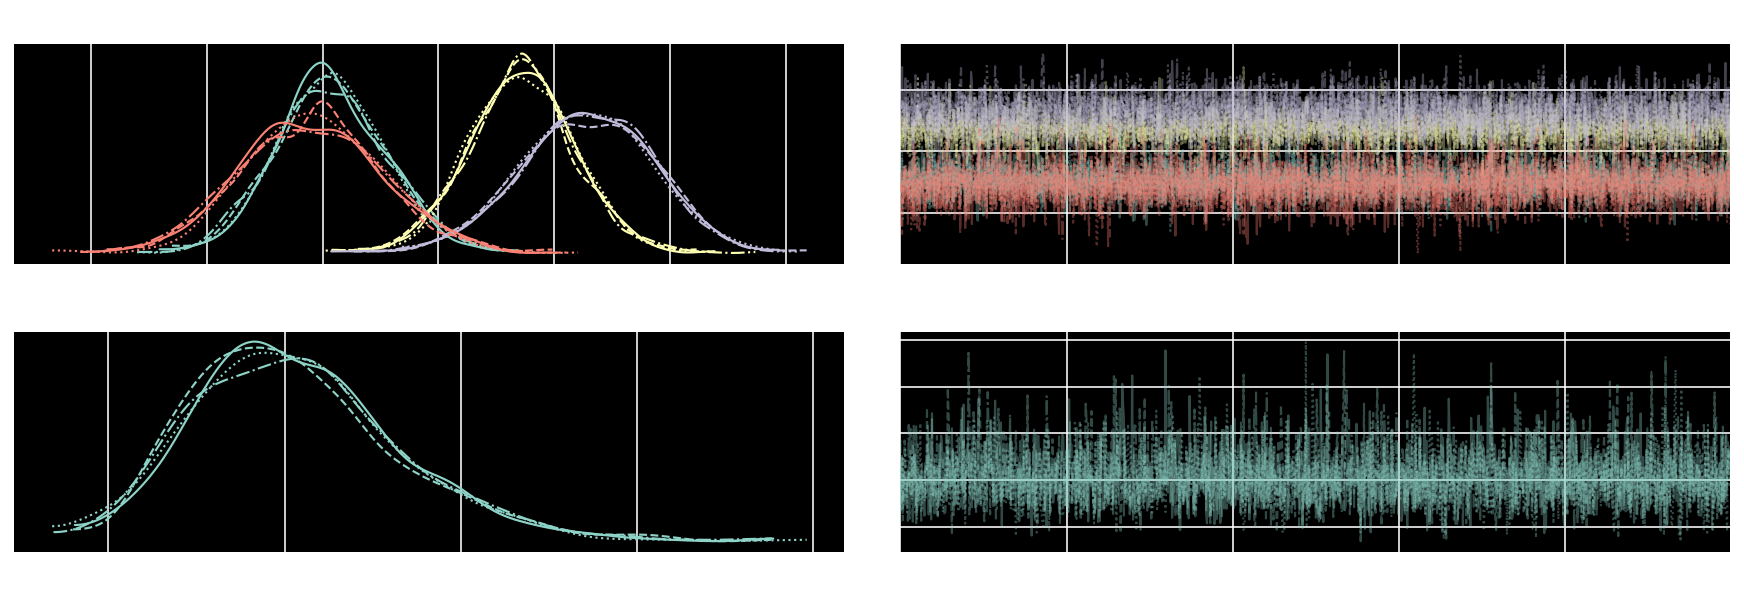

In [272]:
az.plot_trace(trace5_9);

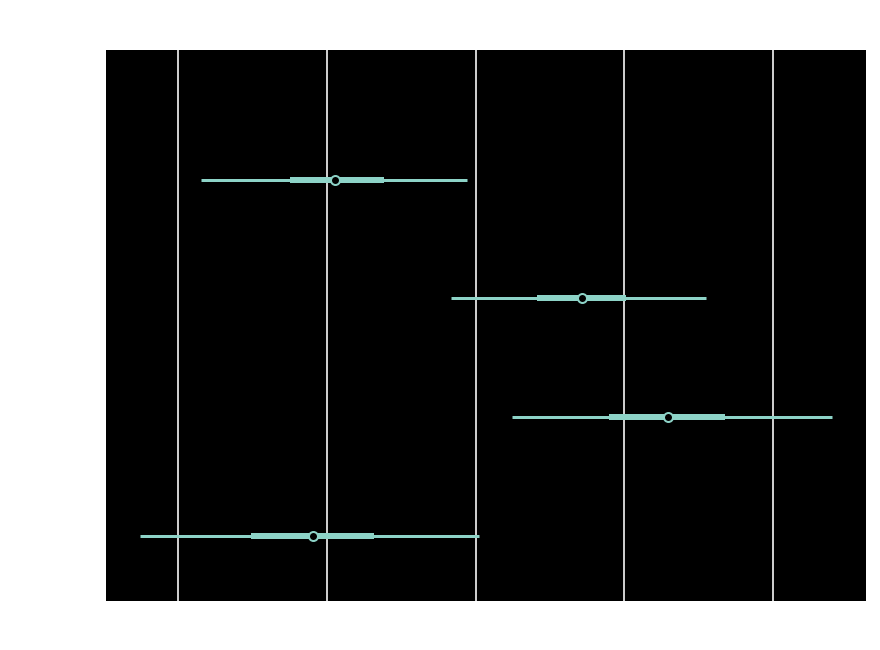

In [291]:
az.plot_forest(trace5_9, var_names=["mu"], combined=True);

6.1 multicollinearity

In [ ]:
with pm.Model() as m63:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bF*d["perc.fat"])
    kcal = pm.Normal("kcal.per.g", mu, s, observed=d["kcal.per.g"])
    trace63 = pm.sample()

with pm.Model() as m64:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bL", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bL*d["perc.lactose"])
    kcal = pm.Normal("kcal.per.g", mu, s, observed=d["kcal.per.g"])
    trace64 = pm.sample()


In [280]:
az.summary(trace63, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.001  0.083  -0.159    0.156      0.001    0.001    5001.0    3001.0   
bF  0.861  0.088   0.690    1.019      0.001    0.001    4629.0    3154.0   
s   0.494  0.070   0.372    0.625      0.001    0.001    3778.0    2388.0   

    r_hat  
a     1.0  
bF    1.0  
s     1.0

In [281]:
az.summary(trace64, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  -0.001  0.072  -0.143    0.126      0.001    0.001    4626.0    2595.0   
bL -0.900  0.079  -1.050   -0.754      0.001    0.001    4939.0    2858.0   
s   0.418  0.060   0.310    0.527      0.001    0.001    4185.0    2691.0   

    r_hat  
a     1.0  
bL    1.0  
s     1.0

percent fat and percent lactose are collinear:

In [283]:
with pm.Model() as m65:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bF*d["perc.fat"] + bL*d["perc.lactose"])
    kcal = pm.Normal("kcal.per.g", mu, s, observed=d["kcal.per.g"])
    trace65 = pm.sample()

az.summary(trace65, var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  -0.002  0.075  -0.148    0.135      0.002    0.001    2187.0    1988.0   
bF  0.249  0.186  -0.140    0.564      0.004    0.003    2218.0    2373.0   
bL -0.673  0.189  -1.041   -0.331      0.004    0.003    2186.0    2341.0   
s   0.420  0.059   0.313    0.528      0.001    0.001    2519.0    2221.0   

    r_hat  
a     1.0  
bF    1.0  
bL    1.0  
s     1.0

/Users/sasha/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


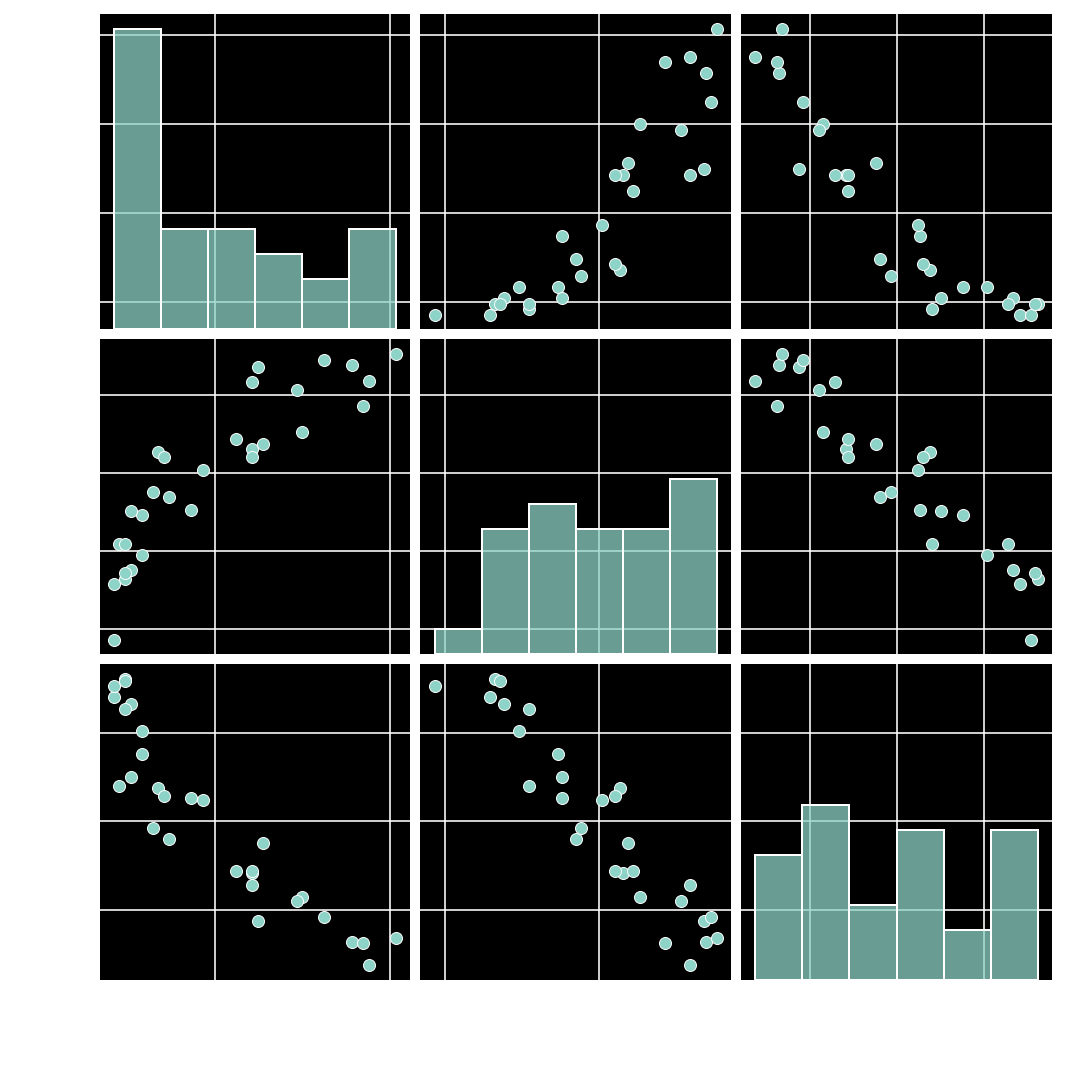

In [290]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

6.2 incorrectly treating post-treatment variables as predictors

In [304]:
n = 100
initial_height = np.random.normal(10, 2, n)
treatment = np.repeat([0,1], n/2)
fungus = np.random.binomial(n=1, p=0.5 - 0.4*treatment, size=n)
final_height = initial_height + np.random.normal(5 - 3*fungus, size=n)
dd = {"h0" : initial_height, "h1": final_height, "treatment": treatment, "fungus": fungus}
d = pd.DataFrame.from_dict(dd)
az.summary(dd, kind="stats")

mean     sd  hdi_3%  hdi_97%
h0         10.224  2.167   5.984   13.457
h1         14.283  2.724   8.912   18.440
treatment   0.500  0.503   0.000    1.000
fungus      0.300  0.461   0.000    1.000

In [305]:
with pm.Model() as m67:
    a = pm.LogNormal("a", 0, 0.25)
    bT = pm.Normal("bT", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)
    s = pm.Exponential("s", 1)
    ## proportion height increase
    p = a + bT*d["treatment"] + bF*d["fungus"]
    ## expected final height = initial height * p
    mu = p * d["h0"]
    h1 = pm.Normal("h1", mu, s, observed=d["h1"])
    trace67 = pm.sample()

az.summary(trace67)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, bF, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bT -0.016  0.028  -0.067    0.038      0.001    0.000    1948.0    2331.0   
bF -0.287  0.030  -0.345   -0.232      0.001    0.001    1778.0    2414.0   
a   1.478  0.024   1.429    1.518      0.001    0.000    1759.0    2357.0   
s   1.233  0.092   1.066    1.399      0.002    0.001    2810.0    2564.0   

    r_hat  
bT    1.0  
bF    1.0  
a     1.0  
s     1.0

treatment has no apparent effect because the model conditioned on fungus

given fungus, treatment has no additional effect

H0 -> H1 <- F <- T

including F breaks the association between T and H1

T and H1 are conditionally independent given F

In [306]:
with pm.Model() as m68:
    a = pm.LogNormal("a", 0, 0.25)
    bT = pm.Normal("bT", 0, 0.5)
    s = pm.Exponential("s", 1)
    ## proportion height increase
    p = a + bT*d["treatment"]
    ## expected final height = initial height * p
    mu = p * d["h0"]
    h1 = pm.Normal("h1", mu, s, observed=d["h1"])
    trace68 = pm.sample()

az.summary(trace68)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bT  0.123  0.033   0.064    0.187      0.001    0.001    1727.0    2543.0   
a   1.318  0.024   1.275    1.366      0.001    0.000    1814.0    2322.0   
s   1.729  0.125   1.488    1.954      0.002    0.002    3045.0    2554.0   

    r_hat  
bT    1.0  
a     1.0  
s     1.0

6.3 collider bias

(selection-distortion effect)

In [14]:
n = 200
#uncorrelated
newsworthiness = np.random.normal(size=n)
trustworthiness = np.random.normal(size=n)
#select the best 10%
score = newsworthiness + trustworthiness
q = np.quantile(score, 0.9)
#correlated
cor = np.corrcoef(newsworthiness[score > q], trustworthiness[score > q])
cor

array([[ 1.        , -0.79850172],
       [-0.79850172,  1.        ]])

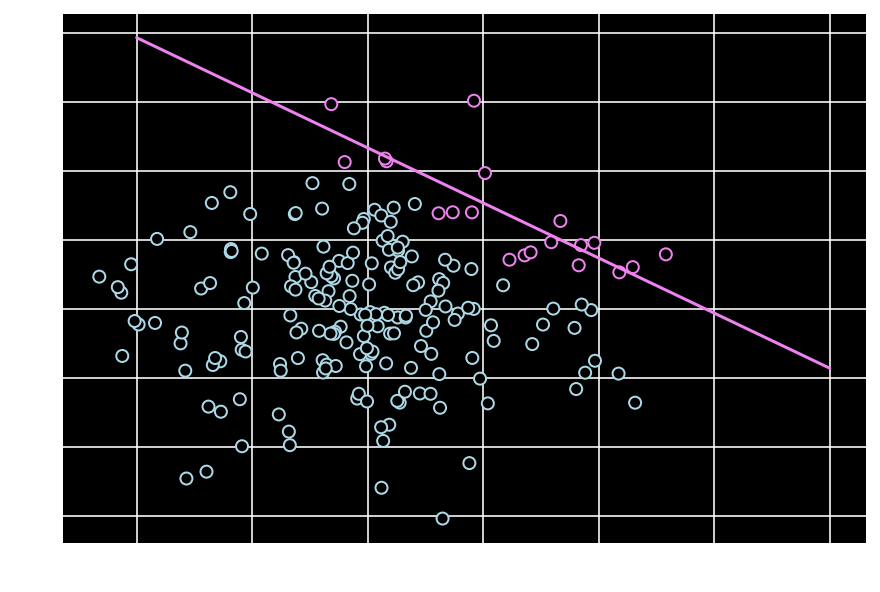

In [15]:
selected = score > q
_, ax = plt.subplots()
ax.scatter(newsworthiness, trustworthiness, lw=1, color="black",
edgecolor = [("violet" if x else "lightblue") for x in selected])

xn = np.array([-2, 4])
plt.plot(xn, trustworthiness[selected].mean() + cor[0, 1] * (xn - newsworthiness[selected].mean())
, color="violet")

In [10]:
from numba import jit

In [85]:
@jit(nopython=True)
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

In [86]:
## numba only a minor speed-up over raw numpy
@jit(nopython=True)
def sim_happ(A, H, M, nyears = 10000):

    for i in range(nyears):
        A += 1
        dead = A > 64
        A[dead] = 0
        M[dead] = 0
        elig = (M == 0) & (A > 17)
        #slower, and numba doesn't like it for some reason
        #mar = np.random.binomial(1, inv_logit(H[elig] - 4.0))
        p = inv_logit(H[elig] - 4.0)
        mar = np.random.rand(p.size) < p
        M[elig] = mar

    return (A, H, M)

In [96]:
## numba much faster if inner loop is needed
@jit(nopython=True)
def sim_happ2(A, H, M, nyears = 10000):

    for i in range(nyears):
        A += 1
        dead = A > 64
        A[dead] = 0
        M[dead] = 0
        for idx, x in enumerate(A):
            if (M[idx] == 0) & (A[idx] > 17):
                p = inv_logit(H[idx] - 4.0)
                M[idx] = np.random.rand() < p

    return (A, H, M)

In [102]:
n = 1000
A = np.repeat(np.arange(65), n)
## numba doesn't like np.tile() for some reason
H = np.tile(np.linspace(-2, 2, n), 65)
M = np.zeros(n * 65)
A, H, M = sim_happ(A, H, M)
dd = {"A": A, "H": H, "M": M}
az.summary(dd, kind="stats")


mean      sd  hdi_3%  hdi_97%
A  32.000  18.762   0.000   61.000
H  -0.000   1.156  -1.992    1.772
M   0.279   0.449   0.000    1.000